## Bonn Database Analysis

#### Importing Libraries

In [41]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from scipy.signal import welch, butter, filtfilt, decimate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### Importing data from the Bonn Database

In [42]:
# Defining classes/directories
directories = ['Z', 'O', 'N', 'F', 'S']
base_path = './bonn_database/'

# Initializing an auxiliar dictionary to store data
data_dict = {
# healthy volunteer data
    "Z": [],  # eyes open
    "O": [],  # eyes closed
# presurgical diagnosis data
    "N": [],  # not seizure - within the lesion area (hipocampus)
    "F": [],  # not seizure - within the other hemisphere's hipocampus
    "S": []   # seizure data
}

original_fs = 173.61 # sampling frequency

# Reading data from each directory
for dir_name in directories:
    dir_path = os.path.join(base_path, dir_name)
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        data = np.loadtxt(file_path)
        data_dict[dir_name].append(data)

# Convert lists to numpy ndarrays
for key in data_dict.keys():
    data_dict[key] = np.array(data_dict[key])

# Print shapes of data for verification
for key, value in data_dict.items():
    print(f" Data {key} shape: {value.shape}")

 Data Z shape: (100, 4097)
 Data O shape: (100, 4097)
 Data N shape: (100, 4097)
 Data F shape: (100, 4097)
 Data S shape: (100, 4097)


#### Filtering and downsampling the data

In [43]:
# defines the filter to be used
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [44]:
# filtering step
lowcut = 0.5
highcut = 40
down_factor = 2 # downsampling factor

filt_dict = {key: decimate(bandpass_filter(data, lowcut, highcut, original_fs), down_factor)
             for key, data in data_dict.items()}

fs = original_fs / down_factor

### Visualizing the EEG's and their spectrum

This is important so we can see the 2 features we are working with:
- The EEG's (raw, time-based data)
- The spectrum of the EEG's (frequency domain data)

In [45]:
# calculates the power spectral density for each data
psd_dict = {}

frequencies = []

for key, item in filt_dict.items():
    frequencies, psd_dict[key] = welch(item, fs=fs, nperseg=256)

print(f"PSD Z shape: {psd_dict["Z"].shape}")
# print(frequencies) # 0-43 Hz, near Nyquist frequency


PSD Z shape: (100, 129)


#### Plotting Samples

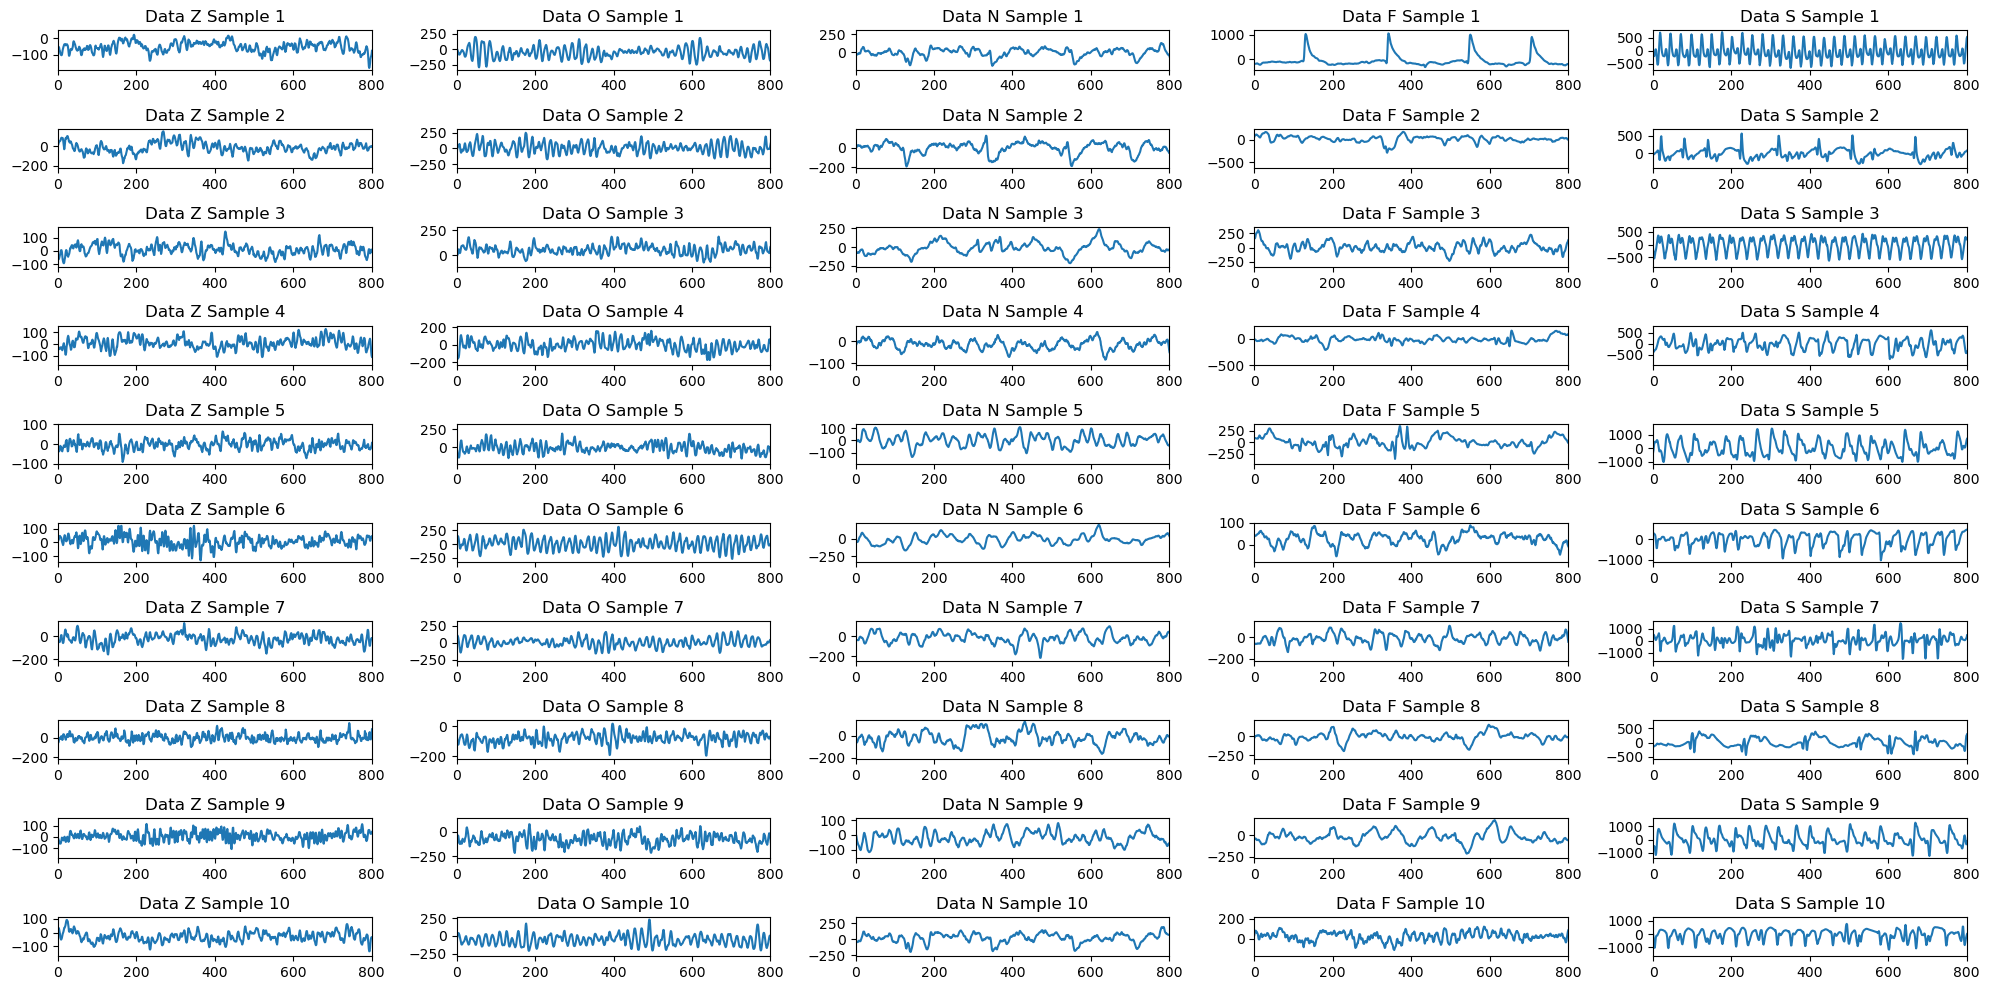

In [46]:
samples_to_plot = 10

# also plot the data in the time domain
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot time domain data for each dataset
for i in range(samples_to_plot):
    for col, class_name in enumerate(data_dict.keys()):
        axs[i, col].plot(data_dict[class_name][i])
        axs[i, col].set_xlim(0, 800)
        axs[i, col].set_title(f'Data {class_name} Sample {i+1}')

plt.tight_layout()
plt.show()

#### Plotting FFT's

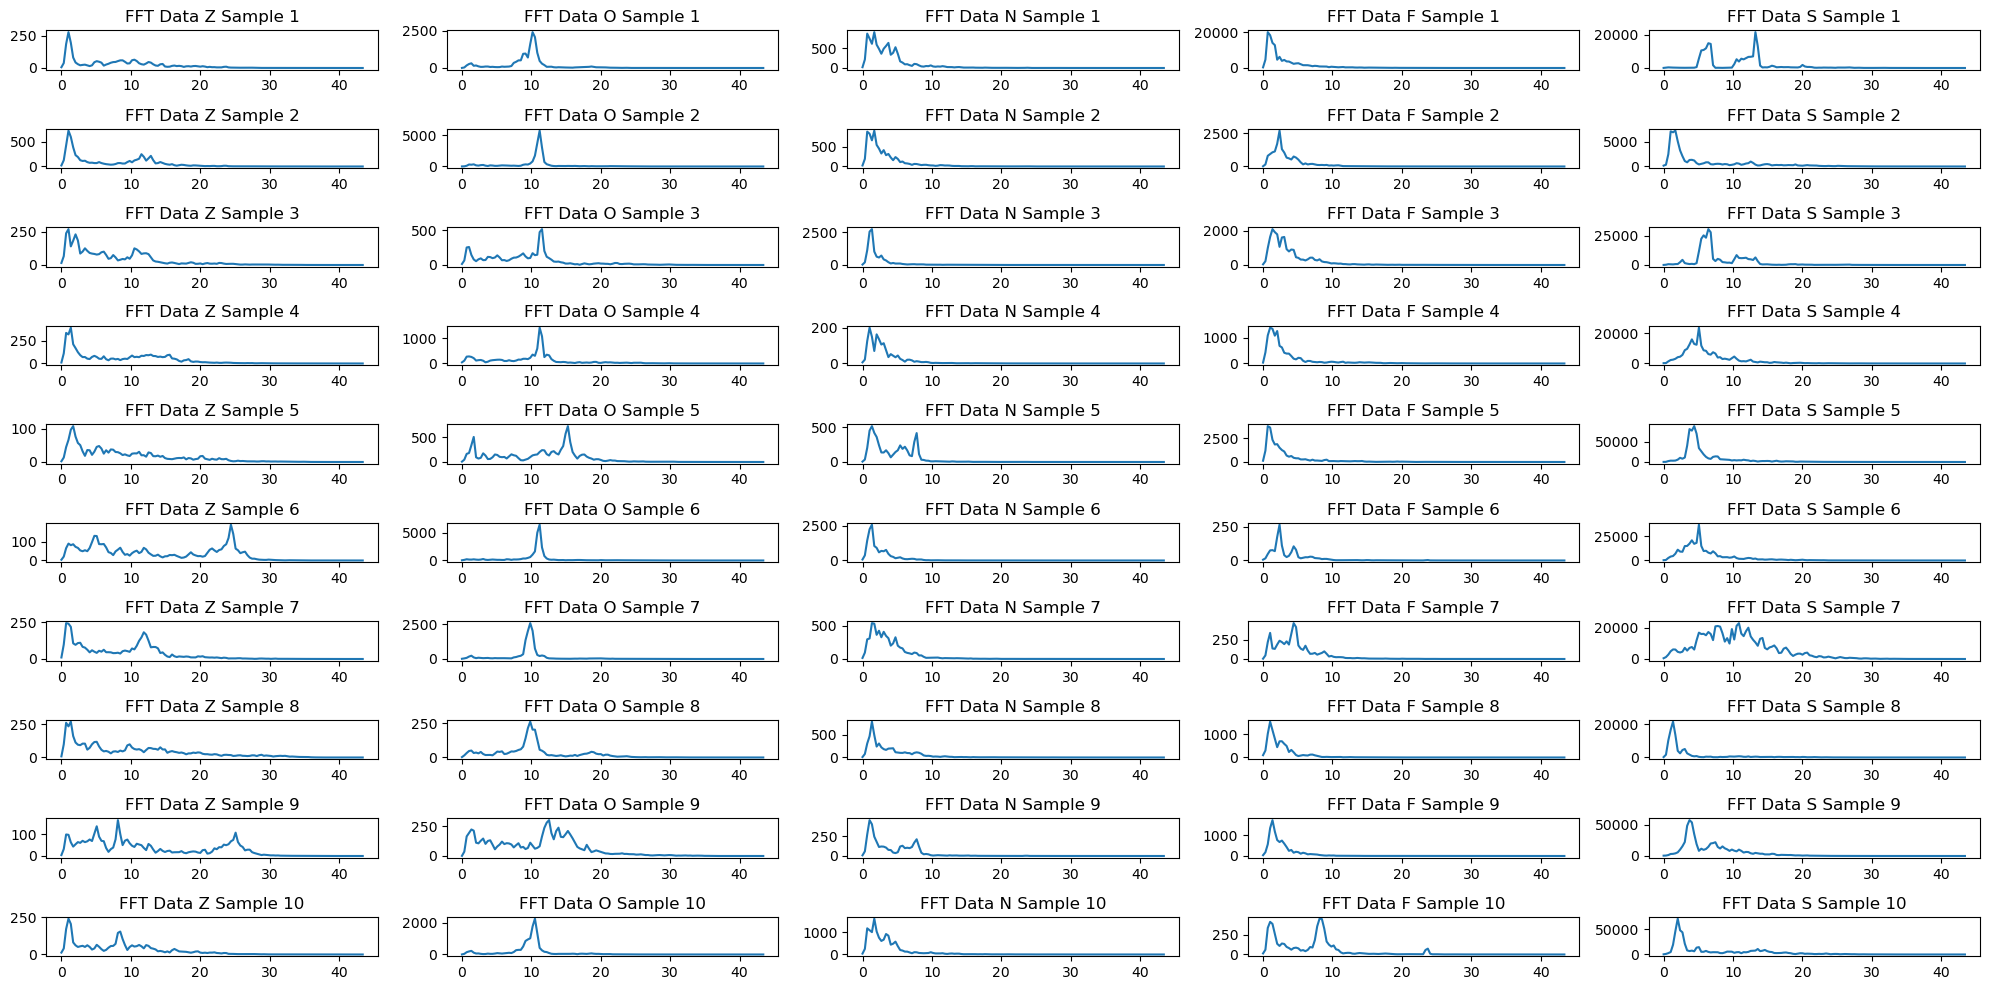

In [47]:
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot FFTs for each dataset
for i in range(samples_to_plot):
    for col, class_name in enumerate(data_dict.keys()):
        axs[i, col].plot(frequencies, psd_dict[class_name][i])
        axs[i, col].set_title(f'FFT Data {class_name} Sample {i+1}')

# Adjust layout
plt.tight_layout()
plt.show()

### Doing some feature engineering
The main features i aim to extract are:

- the power of the EEG on each of the main literature frequency bands (delta, theta, alpha, beta, gamma);
- and the relative power of each of these bands;

Maybe i will also try to extract some other features like the Hjorth parameters, the fractal dimension and the entropy...

In [48]:
def band_power(frequencies, psd, band):
    """ Calcula a potência dentro de uma banda de frequência específica """
    band_idx = np.logical_and(frequencies >= band[0], frequencies <= band[1])  
    return np.trapz(psd[band_idx], frequencies[band_idx])

bands = { # f
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 40)
}

band_powers_df_dict = {}

for key, psd_list in psd_dict.items():
    band_powers_df_dict[key] = pd.DataFrame(
        {band: [band_power(frequencies, psd, bands[band]) for psd in psd_list] for band in bands}
        )

# print(band_powers_df_dict["Z"].shape) # (100, 5), 5 band powers per sample (100 samples)

In [49]:
norm_band_powers_df_dict = {}

for key, band_powers_df in band_powers_df_dict.items():
    norm_band_powers_df_dict[key] = band_powers_df.div(band_powers_df.sum(axis=1), axis=0)

# print(norm_band_powers_df_dict["Z"].shape) # (100, 5), 5 band powers per sample (100 samples)

#### Visualizing the features on a 3d point cloud

In [50]:
import plotly.express as px
import pandas as pd

# combining data onto single df (plotly express requirement)
all_classes_df = pd.concat([
    band_powers_df.assign(Class=key) for key, band_powers_df in band_powers_df_dict.items()
])

classes_to_be_plotted = ["Delta", "Alpha", "Beta"]

# scatter matrix instead of 3d scatter plot
fig = px.scatter_matrix(
    all_classes_df,
    dimensions = bands.keys(),
    color='Class',  # Color by class
    title='3D Scatter Plot of Band Powers',
    # labels={'Delta': 'Delta Power', 'Theta': 'Theta Power', 'Alpha': 'Alpha Power'}
)

fig.show()

### Constructing classifiers based on the 4 different feature sets

#### Separating data between train and test

In [51]:
time_data = {
    key: data for key, data in data_dict.items()
}

frequency_data = {
    key: psd for key, psd in psd_dict.items()
}

band_power_data = {
    key: band_powers_df for key, band_powers_df in band_powers_df_dict.items()
}

normalized_band_power_data = {
    key: norm_band_powers_df for key, norm_band_powers_df in norm_band_powers_df_dict.items()
}

# split data in dict's into train and test sets
def split_data(data_dict, test_size=0.2, random_state=42):
    X = []
    y = []
    for label, data in data_dict.items():
        X.append(data)
        y.extend([label] * len(data))
    X = np.vstack(X)
    y = np.array(y)
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# splitting data into train and test sets
X_train_time, X_test_time, y_train_time, y_test_time = split_data(time_data)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = split_data(frequency_data)
X_train_band, X_test_band, y_train_band, y_test_band = split_data(band_power_data)
X_train_norm_band, X_test_norm_band, y_train_norm_band, y_test_norm_band = split_data(normalized_band_power_data)

# printing shapes for berification
print("Time-domain data:", X_train_time.shape, X_test_time.shape)
print("Frequency-domain data:", X_train_freq.shape, X_test_freq.shape)
print("Band power data:", X_train_band.shape, X_test_band.shape)
print("Normalized band power data:", X_train_norm_band.shape, X_test_norm_band.shape)

Time-domain data: (400, 4097) (100, 4097)
Frequency-domain data: (400, 129) (100, 129)
Band power data: (400, 5) (100, 5)
Normalized band power data: (400, 5) (100, 5)


##### Setting up a model gatherer dictionary for later analysis

In [52]:
models = {
    "MLP Time-Domain": {
        "X_test": X_test_time,
        "y_test": y_test_time,
        "model": None  # to be stored...
    },
    "MLP Frequency-Domain": {
        "X_test": X_test_freq,
        "y_test": y_test_freq,
        "model": None
    },
    "MLP Band Power": {
        "X_test": X_test_band,
        "y_test": y_test_band,
        "model": None
    },
    "MLP Normalized Band Power": {
        "X_test": X_test_norm_band,
        "y_test": y_test_norm_band,
        "model": None
    },
    "MLP Expanded Features": {
        "X_test": None,
        "y_test": None,
        "model": None
    },
    "CNN Time-Domain": {
        "X_test": X_test_time.reshape(X_test_time.shape[0], X_test_time.shape[1], 1),
        "y_test": y_test_time,
        "model": None
    },
    "CNN Frequency-Domain": {
        "X_test": X_test_freq.reshape(X_test_freq.shape[0], X_test_freq.shape[1], 1),
        "y_test": y_test_freq,
        "model": None
    }
}

#### Setting up generic MLP classifiers

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Input, Normalization, Dropout
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
os.environ["KERAS_BACKEND"] = "torch"

# Function to create a basic MLP model
def create_mlp(input_dim, num_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Normalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='Nadam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, feature_name):
    # Encode labels
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
    # One-hot encode labels
    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
    # Creating the model and adapting it to the training data
    model = create_mlp(X_train.shape[1], num_classes=y_train_categorical.shape[1])
    model.layers[0].adapt(X_train)

    # Displaying model summary
    model.summary()

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        min_delta=0.001,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train_categorical,
        epochs=200,
        batch_size=8,
        verbose=1,
        validation_split=0.2,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
    print(f"{feature_name} - Test Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))

    # figure for accuracy and loss plots
    plt.figure(figsize=(20, 6))

    # plotting accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{feature_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # plotting loss too
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{feature_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # plotting the confusion matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    
    # Normalize confusion matrix (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot with seaborn for better visualization
    ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                    xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'{feature_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.tight_layout()
    plt.show()

    return model, history

#### Training the MLP's

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_10                │ (None, 4097)           │         8,195 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,872 (1.06 MB)

 Trainable params: 268,677 (1.02 MB)

 Non-trainable params: 8,195 (32.01 KB)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2465 - loss: 2.3607 - val_accuracy: 0.3375 - val_loss: 1.5189
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2540 - loss: 1.9267 - val_accuracy: 0.3500 - val_loss: 1.4027
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3595 - loss: 1.7357 - val_accuracy: 0.4500 - val_loss: 1.3477
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3756 - loss: 1.5306 - val_accuracy: 0.5250 - val_loss: 1.2908
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4213 - loss: 1.4353 - val_accuracy: 0.4750 - val_loss: 1.2905
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4449 - loss: 1.4160 - val_accuracy: 0.4750 - val_loss: 1.2718
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4647 - loss: 1.2193 - val_accuracy: 0.4500 - val_loss: 1.2621
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4882 - loss: 1.3973 - val_accuracy: 0.4750 - 

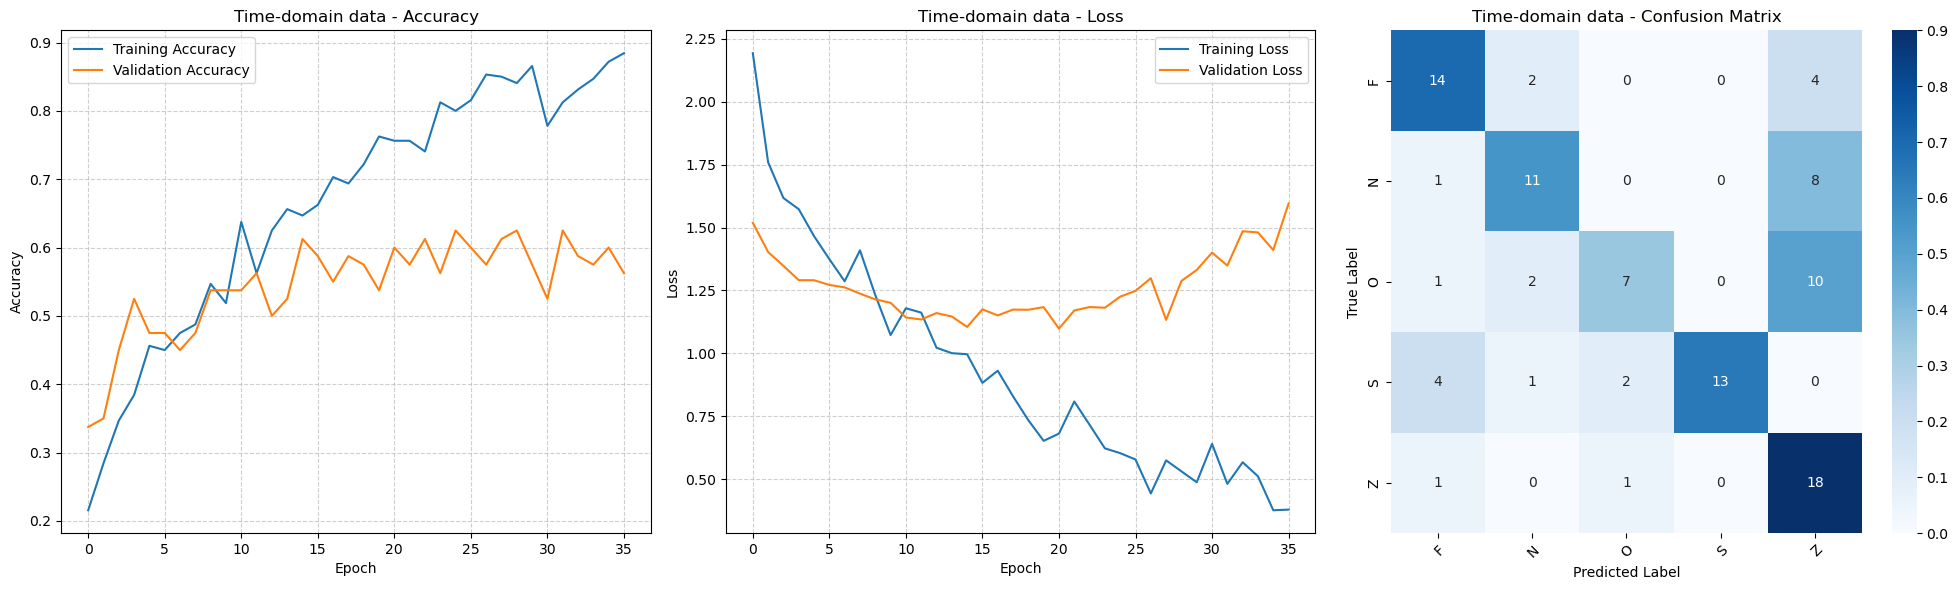

In [54]:
# Train and evaluate classifiers for each feature set
model, _ = train_and_evaluate(X_train_time, X_test_time, y_train_time, y_test_time, "Time-domain data")
models["MLP Time-Domain"]["model"] = model

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_11                │ (None, 129)            │           259 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,984 (58.53 KB)

 Trainable params: 14,725 (57.52 KB)

 Non-trainable params: 259 (1.01 KB)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1980 - loss: 1.6821 - val_accuracy: 0.3125 - val_loss: 1.4821
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2926 - loss: 1.5135 - val_accuracy: 0.5250 - val_loss: 1.4463
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3347 - loss: 1.4420 - val_accuracy: 0.3750 - val_loss: 1.4198
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3982 - loss: 1.3469 - val_accuracy: 0.4000 - val_loss: 1.3862
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3896 - loss: 1.3580 - val_accuracy: 0.5000 - val_loss: 1.3638
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4361 - loss: 1.3109 - val_accuracy: 0.3625 - val_loss: 1.3170
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4281 - loss: 1.3710 - val_accuracy: 0.4375 - val_loss: 1.2884
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3677 - loss: 1.3042 - val_accuracy: 0.5375 - v

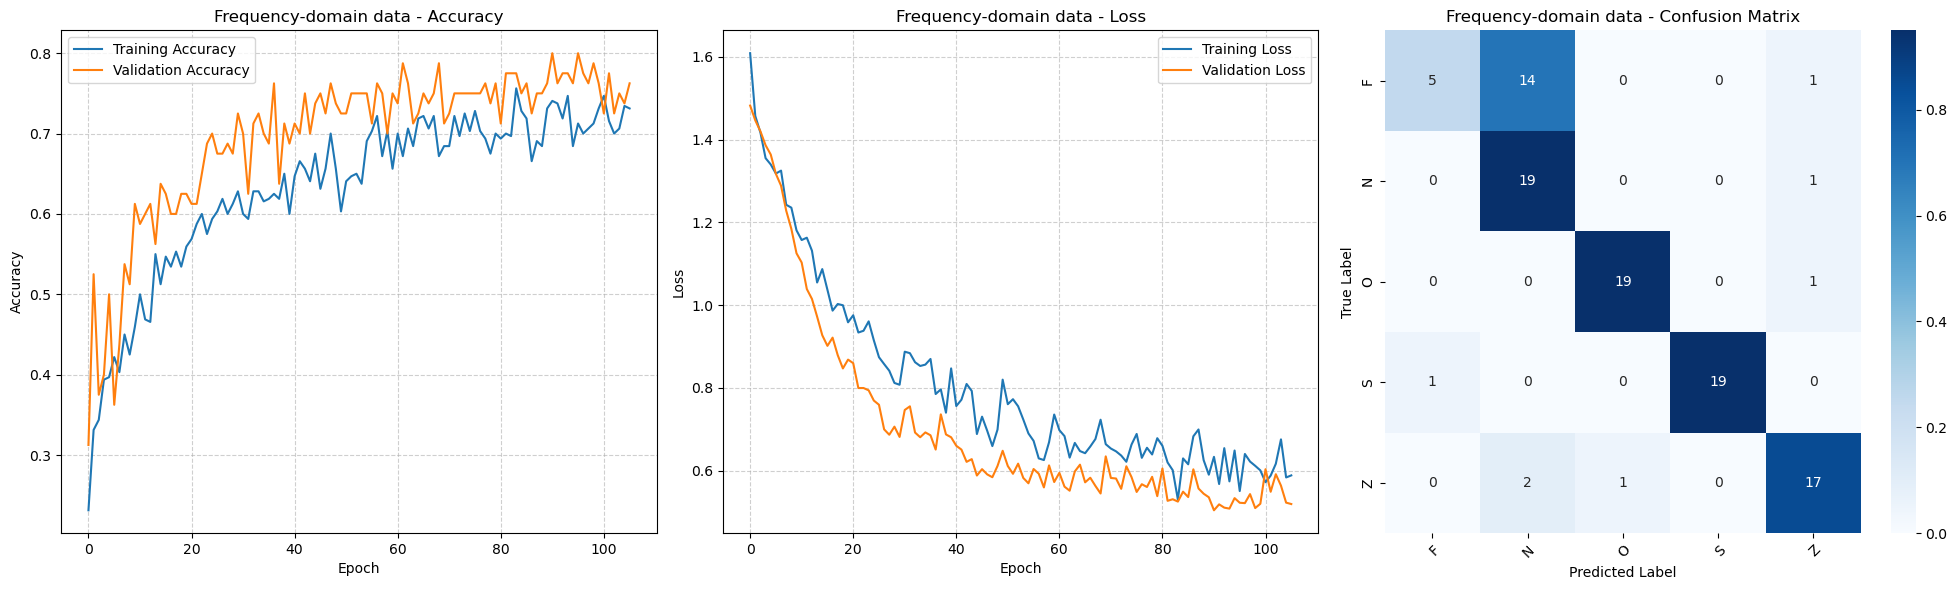

In [55]:
model, _ = train_and_evaluate(X_train_freq, X_test_freq, y_train_freq, y_test_freq, "Frequency-domain data")
models["MLP Frequency-Domain"]["model"] = model

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_12                │ (None, 5)              │            11 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,800 (26.56 KB)

 Trainable params: 6,789 (26.52 KB)

 Non-trainable params: 11 (44.00 B)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2176 - loss: 1.6303 - val_accuracy: 0.3750 - val_loss: 1.5481
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3073 - loss: 1.5112 - val_accuracy: 0.3000 - val_loss: 1.4924
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3474 - loss: 1.4631 - val_accuracy: 0.3000 - val_loss: 1.4445
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3485 - loss: 1.4058 - val_accuracy: 0.3125 - val_loss: 1.3986
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3916 - loss: 1.3460 - val_accuracy: 0.3125 - val_loss: 1.3594
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4152 - loss: 1.3299 - val_accuracy: 0.3125 - val_loss: 1.3282
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4179 - loss: 1.2542 - val_accuracy: 0.3625 - val_loss: 1.2986
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3933 - loss: 1.2790 - val_accuracy: 0.5125 - v

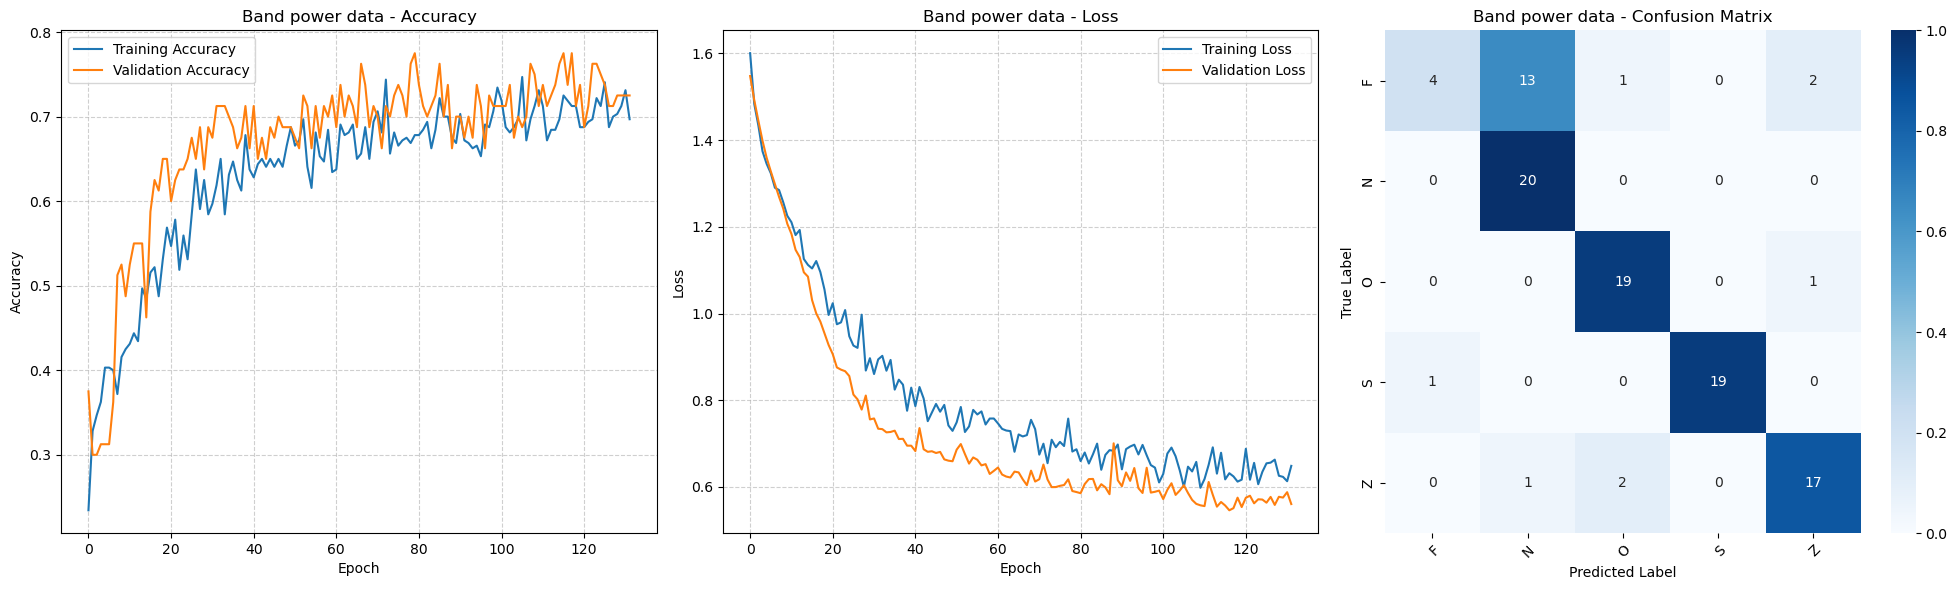

In [56]:
model, _ = train_and_evaluate(X_train_band, X_test_band, y_train_band, y_test_band, "Band power data")
models["MLP Band Power"]["model"] = model

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_13                │ (None, 5)              │            11 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,800 (26.56 KB)

 Trainable params: 6,789 (26.52 KB)

 Non-trainable params: 11 (44.00 B)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2123 - loss: 1.6090 - val_accuracy: 0.5375 - val_loss: 1.4471
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3699 - loss: 1.4197 - val_accuracy: 0.5375 - val_loss: 1.2501
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4392 - loss: 1.3053 - val_accuracy: 0.5375 - val_loss: 1.0777
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4740 - loss: 1.1842 - val_accuracy: 0.5625 - val_loss: 0.9606
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5346 - loss: 1.0579 - val_accuracy: 0.6250 - val_loss: 0.8767
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5046 - loss: 1.0387 - val_accuracy: 0.6750 - val_loss: 0.8244
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5973 - loss: 0.9370 - val_accuracy: 0.6625 - val_loss: 0.7802
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5693 - loss: 0.9886 - val_accuracy: 0.6750 - 

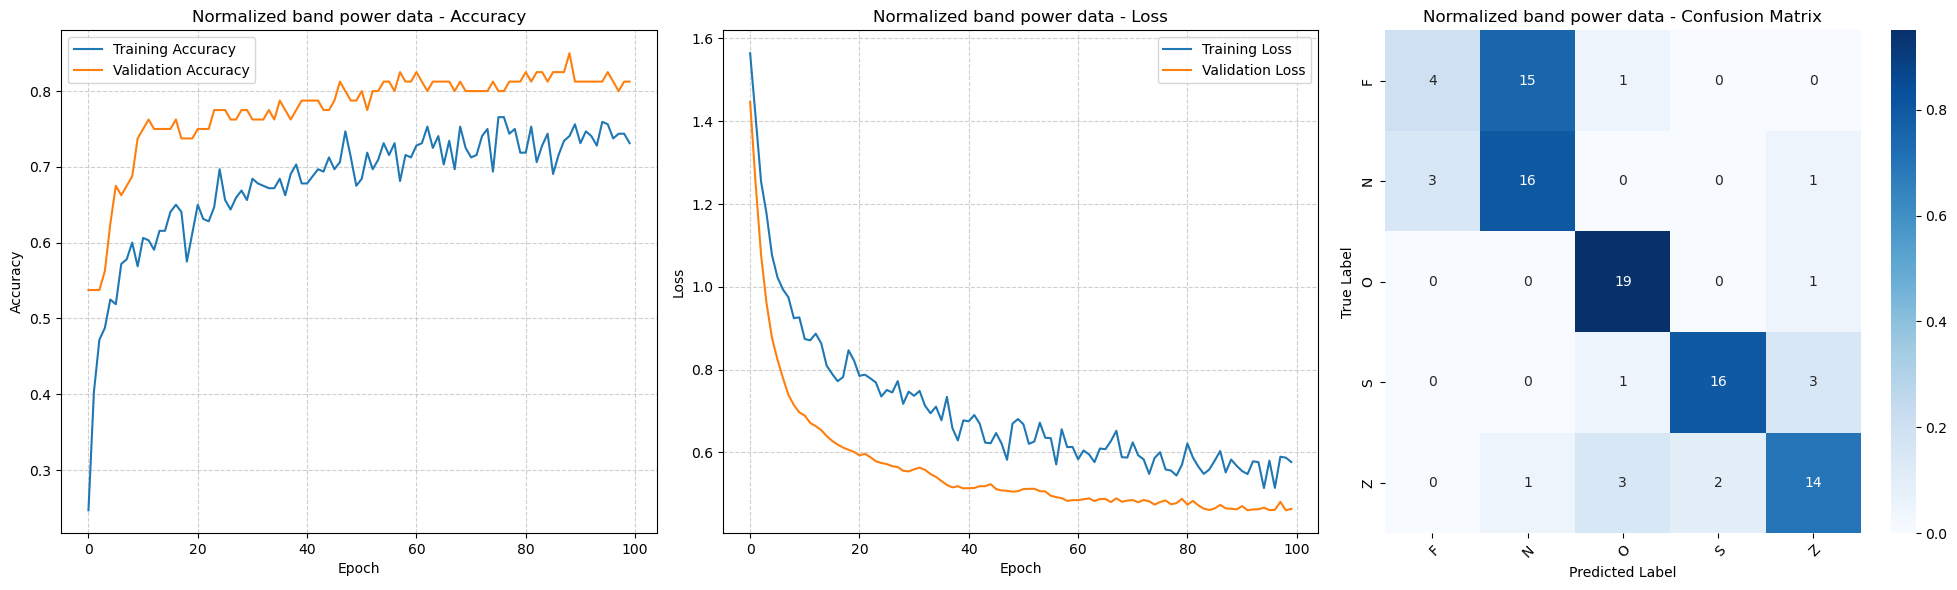

In [57]:
model, _ = train_and_evaluate(X_train_norm_band, X_test_norm_band, y_train_norm_band, y_test_norm_band, "Normalized band power data")
models["MLP Normalized Band Power"]["model"] = model

#### Experimenting with the band power based classifier

##### Calculating other important features

In [58]:
from scipy.stats import entropy

expanded_band_power_dict = {}

for key, band_powers_df in band_powers_df_dict.items():
    # Create a new DataFrame for each class
    expanded_features = band_powers_df.copy()
    
    # 1. Add relative band powers (normalize by total power)
    total_power = band_powers_df.sum(axis=1)
    for band in bands.keys():
        expanded_features[f'Rel_{band}'] = band_powers_df[band] / total_power
    
    # 2. Add band power ratios
    expanded_features['Theta_Alpha_Ratio'] = band_powers_df['Theta'] / band_powers_df['Alpha']
    expanded_features['Beta_Alpha_Ratio'] = band_powers_df['Beta'] / band_powers_df['Alpha']
    expanded_features['Gamma_Beta_Ratio'] = band_powers_df['Gamma'] / band_powers_df['Beta']
    expanded_features['HighLow_Ratio'] = (band_powers_df['Beta'] + band_powers_df['Gamma']) / (band_powers_df['Delta'] + band_powers_df['Theta'])
    
    # 3. Calculate spectral entropy for each sample from the original frequency data
    spectral_entropy = []
    for i in range(len(psd_dict[key])):
        # Normalize PSD (probability distribution)
        psd = psd_dict[key][i]
        psd_norm = psd / np.sum(psd)
        # Calculate entropy
        spectral_entropy.append(entropy(psd_norm))
    
    expanded_features['Spectral_Entropy'] = spectral_entropy
    
    # 4. Calculate band entropy (entropy within each frequency band)
    for band_name, (low_freq, high_freq) in bands.items():
        band_entropy = []
        for i in range(len(psd_dict[key])):
            band_idx = np.logical_and(frequencies >= low_freq, frequencies <= high_freq)
            band_psd = psd_dict[key][i][band_idx]
            # Skip if band has no frequency components
            if len(band_psd) > 1:
                band_psd_norm = band_psd / np.sum(band_psd)
                band_entropy.append(entropy(band_psd_norm))
            else:
                band_entropy.append(0)  # Default if not enough data points
        
        expanded_features[f'{band_name}_Entropy'] = band_entropy
    
    # Store in the new dictionary
    expanded_band_power_dict[key] = expanded_features

# Print summary of expanded features
sample_key = list(expanded_band_power_dict.keys())[0]
print(f"Original features: {list(band_powers_df_dict[sample_key].columns)}")
print(f"Expanded features: {list(expanded_band_power_dict[sample_key].columns)}")
print(f"Number of features: {len(expanded_band_power_dict[sample_key].columns)}")
print(f"Shape of expanded features for {sample_key}: {expanded_band_power_dict[sample_key].shape}")

Original features: ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
Expanded features: ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Rel_Delta', 'Rel_Theta', 'Rel_Alpha', 'Rel_Beta', 'Rel_Gamma', 'Theta_Alpha_Ratio', 'Beta_Alpha_Ratio', 'Gamma_Beta_Ratio', 'HighLow_Ratio', 'Spectral_Entropy', 'Delta_Entropy', 'Theta_Entropy', 'Alpha_Entropy', 'Beta_Entropy', 'Gamma_Entropy']
Number of features: 20
Shape of expanded features for Z: (100, 20)


##### Setting up a model with the new expanded features

In [59]:
# splitting expanded band power data into train and test sets
X_train_expanded, X_test_expanded, y_train_expanded, y_test_expanded = split_data(expanded_band_power_dict)
# printing shapes for verification
print("Expanded Band Power data:", X_train_expanded.shape, X_test_expanded.shape)

models["MLP Expanded Features"]["X_test"] = X_test_expanded
models["MLP Expanded Features"]["y_test"] = y_test_expanded

Expanded Band Power data: (400, 20) (100, 20)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_14                │ (None, 20)             │            41 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,686 (18.30 KB)

 Trainable params: 4,645 (18.14 KB)

 Non-trainable params: 41 (164.00 B)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2027 - loss: 1.6845 - val_accuracy: 0.4625 - val_loss: 1.4526
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3205 - loss: 1.5565 - val_accuracy: 0.5875 - val_loss: 1.2753
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4751 - loss: 1.3031 - val_accuracy: 0.6250 - val_loss: 1.0908
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5762 - loss: 1.1178 - val_accuracy: 0.6875 - val_loss: 0.9242
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5689 - loss: 1.0404 - val_accuracy: 0.7375 - val_loss: 0.8170
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5466 - loss: 0.9590 - val_accuracy: 0.7125 - val_loss: 0.7546
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5752 - loss: 0.8228 - val_accuracy: 0.7375 - val_loss: 0.7028
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6081 - loss: 0.8482 - val_accuracy: 0.7125 - v

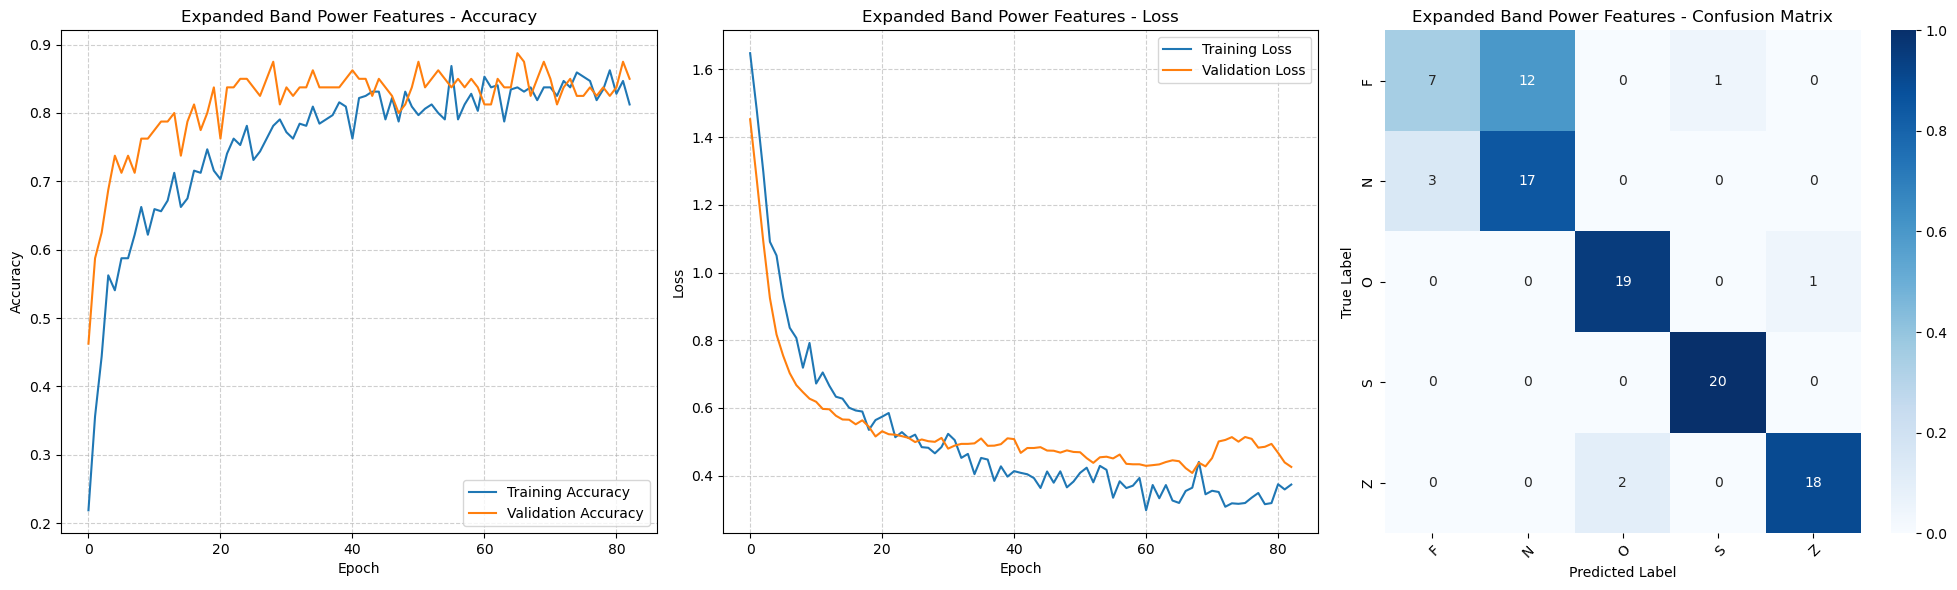

In [60]:
# doing the label encoding
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_expanded)
y_test_encoded = encoder.transform(y_test_expanded)

# one-hot label encoding
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

expanded_band_model = Sequential([
    Input(shape=(X_train_expanded.shape[1],)),
    Normalization(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

expanded_band_model.layers[0].adapt(X_train_expanded)

# Displaying model summary
expanded_band_model.summary()

expanded_band_model.compile(
    optimizer='Nadam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# training the model
history = expanded_band_model.fit(
    X_train_expanded, y_train_categorical,
    epochs=200,
    batch_size=8,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stopping]
)
models["MLP Expanded Features"]["model"] = expanded_band_model

feature_name = "Expanded Band Power Features"
# Evaluate the model
loss, accuracy = expanded_band_model.evaluate(X_test_expanded, y_test_categorical, verbose=0)
print(f"{feature_name} - Test Accuracy: {accuracy:.4f}")

# Generate classification report
y_pred = expanded_band_model.predict(X_test_expanded)
y_pred_classes = y_pred.argmax(axis=1)
print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))

# figure for accuracy and loss plots
plt.figure(figsize=(20, 6))

# plotting accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{feature_name} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# plotting loss too
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{feature_name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# plotting the confusion matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Normalize confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot with seaborn for better visualization
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title(f'{feature_name} - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

#### Setting up CNN's to classify time and frequency data

In [67]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Function to create a CNN model for 1D time series data
def create_cnn_time(input_shape, num_classes):
    model = Sequential([
        # Input shape: (sequence_length, 1)
        Input(input_shape),
        Normalization(),
        Conv1D(16, kernel_size=32, strides=[4], activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=8),
        Conv1D(16, kernel_size=4, activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    if torch.cuda.is_available():
        model = model.to("cuda")

    model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to create a CNN model for frequency domain data (shorter sequences)
def create_cnn_freq(input_shape, num_classes):
    model = Sequential([
        # Input shape: (sequence_length, 1)
        Input(input_shape),
        Normalization(),
        Conv1D(16, kernel_size=4, activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=2),
        Conv1D(16, kernel_size=2, activation='relu'),
        Dropout(0.3),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='Nadam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

# Function to train and evaluate the CNN models
def train_and_evaluate_cnn(X_train, X_test, y_train, y_test, feature_name, is_time_domain=True):
    # Reshape data for CNN input - adding channel dimension
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Encode labels
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
    # One-hot encode labels
    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
# Create and train the model based on domain type
    if is_time_domain:
        model = create_cnn_time((X_train.shape[1], 1), num_classes=y_train_categorical.shape[1])
    else:
        model = create_cnn_freq((X_train.shape[1], 1), num_classes=y_train_categorical.shape[1])
    
    model.layers[0].adapt(X_train_reshaped)

# Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        min_delta=0.001,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

# Train the model
    history = model.fit(
        X_train_reshaped, 
        y_train_categorical, 
        epochs=200, 
        batch_size=16,
        verbose=1,
        validation_split=0.2,
        callbacks=[early_stopping]
    )
    
# Evaluate the model
    loss, accuracy = model.evaluate(X_test_reshaped, y_test_categorical, verbose=0)
    print(f"CNN {feature_name} - Test Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    y_pred = model.predict(X_test_reshaped)
    y_pred_classes = y_pred.argmax(axis=1)
    print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))
    
    # figure for accuracy and loss plots
    plt.figure(figsize=(20, 6))

# plotting accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{feature_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # plotting loss too
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{feature_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
# Compute and plot confusion matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    
    # Normalize confusion matrix (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot with seaborn for better visualization
    ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                    xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'{feature_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.tight_layout()
    plt.show()

    return model

##### Displaying the network summaries

In [62]:
# Print model summaries
print("CNN Model for Time-Domain Data:")
time_model = create_cnn_time((X_train_time.shape[1], 1), 5)
time_model.summary()

print("\nCNN Model for Frequency-Domain Data:")
freq_model = create_cnn_freq((X_train_freq.shape[1], 1), 5)
freq_model.summary()

CNN Model for Time-Domain Data:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_15                │ (None, 4097, 1)        │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1017, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1017, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 127, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 16)        │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 124, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 31, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 16)             │         7,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,608 (37.53 KB)

 Trainable params: 9,605 (37.52 KB)

 Non-trainable params: 3 (12.00 B)


CNN Model for Frequency-Domain Data:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_16                │ (None, 129, 1)         │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 126, 16)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 126, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 63, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 62, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 62, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 31, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 16)             │         7,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648 (33.78 KB)

 Trainable params: 8,645 (33.77 KB)

 Non-trainable params: 3 (12.00 B)

##### Training the CNN's


=== Training CNN on Time-Domain Data ===
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2728 - loss: 1.5132 - val_accuracy: 0.1875 - val_loss: 1.5138
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2936 - loss: 1.4762 - val_accuracy: 0.3625 - val_loss: 1.4709
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3368 - loss: 1.3200 - val_accuracy: 0.5375 - val_loss: 1.4418
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4268 - loss: 1.3192 - val_accuracy: 0.6125 - val_loss: 1.3575
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5742 - loss: 1.2376 - val_accuracy: 0.6250 - val_loss: 1.2659
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5873 - loss: 1.0722 - val_accuracy: 0.6125 - val_loss: 1.1318
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6348 - loss: 0.9063 - val_accuracy: 0.6875 - val_loss: 1.0353
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6398

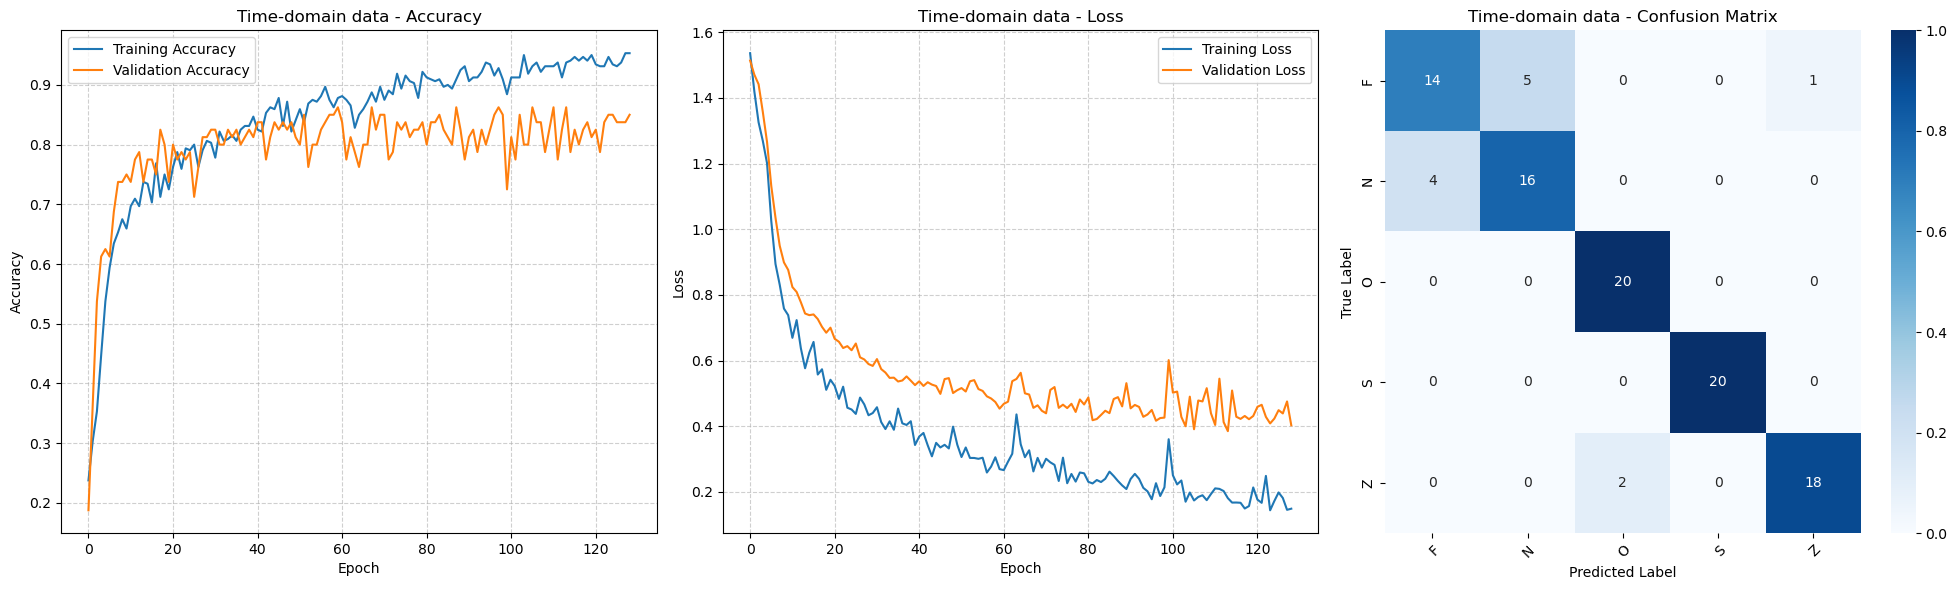

In [68]:
# Train and evaluate CNN for time-domain data
print("\n=== Training CNN on Time-Domain Data ===")
time_cnn_model = train_and_evaluate_cnn(X_train_time, X_test_time, y_train_time, y_test_time, 
                                        "Time-domain data", is_time_domain=True)
models["CNN Time-Domain"]["model"] = time_cnn_model


=== Training CNN on Frequency-Domain Data ===
Epoch 1/200
 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2469 - loss: 1.6141

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2841 - loss: 1.5718 - val_accuracy: 0.3625 - val_loss: 1.5262
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3822 - loss: 1.4552 - val_accuracy: 0.4375 - val_loss: 1.4891
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4118 - loss: 1.3958 - val_accuracy: 0.4250 - val_loss: 1.4511
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4032 - loss: 1.3705 - val_accuracy: 0.4875 - val_loss: 1.4130
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4395 - loss: 1.3210 - val_accuracy: 0.5000 - val_loss: 1.3840
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4166 - loss: 1.3484 - val_accuracy: 0.4375 - val_loss: 1.3490
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4695 - loss: 1.2411 - val_accuracy: 0.5875 - val_loss: 1.3034
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4856 - loss: 1.2425 - val_accuracy: 0.5500 - val_loss: 

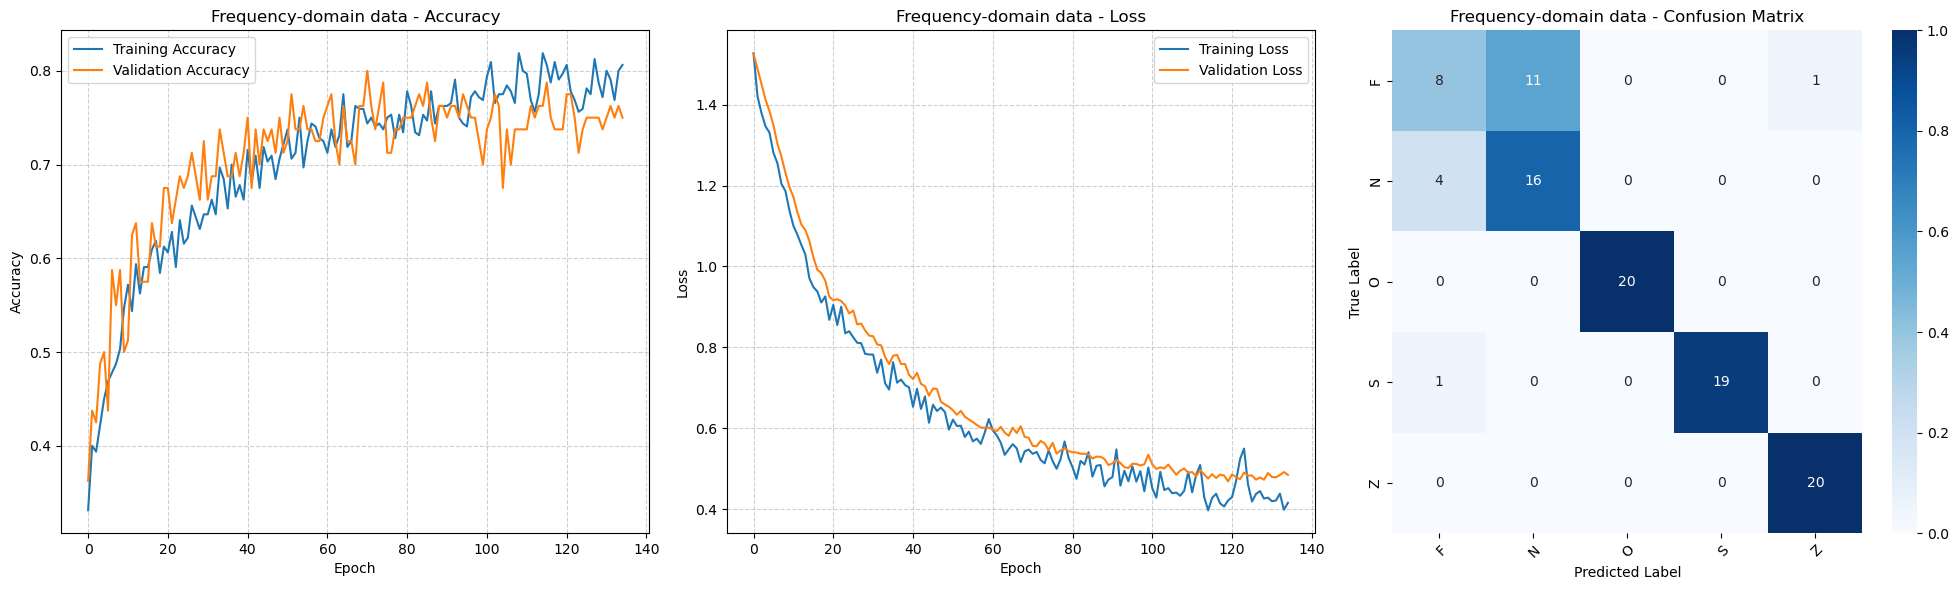

In [69]:
# Train and evaluate CNN for frequency-domain data
print("\n=== Training CNN on Frequency-Domain Data ===")
freq_cnn_model = train_and_evaluate_cnn(X_train_freq, X_test_freq, y_train_freq, y_test_freq, 
                                        "Frequency-domain data", is_time_domain=False)
models["CNN Frequency-Domain"]["model"] = freq_cnn_model

### Conclusions?

#### defining the main classification tasks

In [74]:
# Define the classification tasks
classification_tasks = {
    "All Classes": {
        "description": "All 5 EEG classes",
        "mapping": {
            "Z": "Z", "O": "O", "N": "N", "F": "F", "S": "S"
        }
    },
    "Healthy vs Unhealthy": {
        "description": "Healthy (Z, O) vs Unhealthy (N, F, S)",
        "mapping": {
            "Z": "Healthy", "O": "Healthy", "N": "Unhealthy", "F": "Unhealthy", "S": "Unhealthy"
        }
    },
    "Seizure vs Non-Seizure": {
        "description": "Seizure (S) vs Non-Seizure (Z, O, N, F)",
        "mapping": {
            "Z": "Non-Seizure", "O": "Non-Seizure", "N": "Non-Seizure", "F": "Non-Seizure", "S": "Seizure"
        }
    },
    "N-I vs I-I vs I": {
        "description": "Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ictal (S)",
        "mapping": {
            "Z": "Non-Ictal", "O": "Non-Ictal", "N": "Inter-Ictal", "F": "Inter-Ictal", "S": "Ictal"
        }
    },
    "Eyes Open vs Closed": {
        "description": "Eyes Open (Z) vs Eyes Closed (O) [Healthy only]",
        "mapping": {
            "Z": "Eyes Open", "O": "Eyes Closed", "N": None, "F": None, "S": None
        }
    }
}

#### doing the main comparisons between models

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMet

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: Unde

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                        Model                    Task  \
0             MLP Time-Domain             All Classes   
1             MLP Time-Domain    Healthy vs Unhealthy   
2             MLP Time-Domain  Seizure vs Non-Seizure   
3             MLP Time-Domain         N-I vs I-I vs I   
4             MLP Time-Domain     Eyes Open vs Closed   
5        MLP Frequency-Domain             All Classes   
6        MLP Frequency-Domain    Healthy vs Unhealthy   
7        MLP Frequency-Domain  Seizure vs Non-Seizure   
8        MLP Frequency-Domain         N-I vs I-I vs I   
9        MLP Frequency-Domain     Eyes Open vs Closed   
10             MLP Band Power             All Classes   
11             MLP Band Power    Healthy vs Unhealthy   
12             MLP Band Power  Seizur

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: Unde

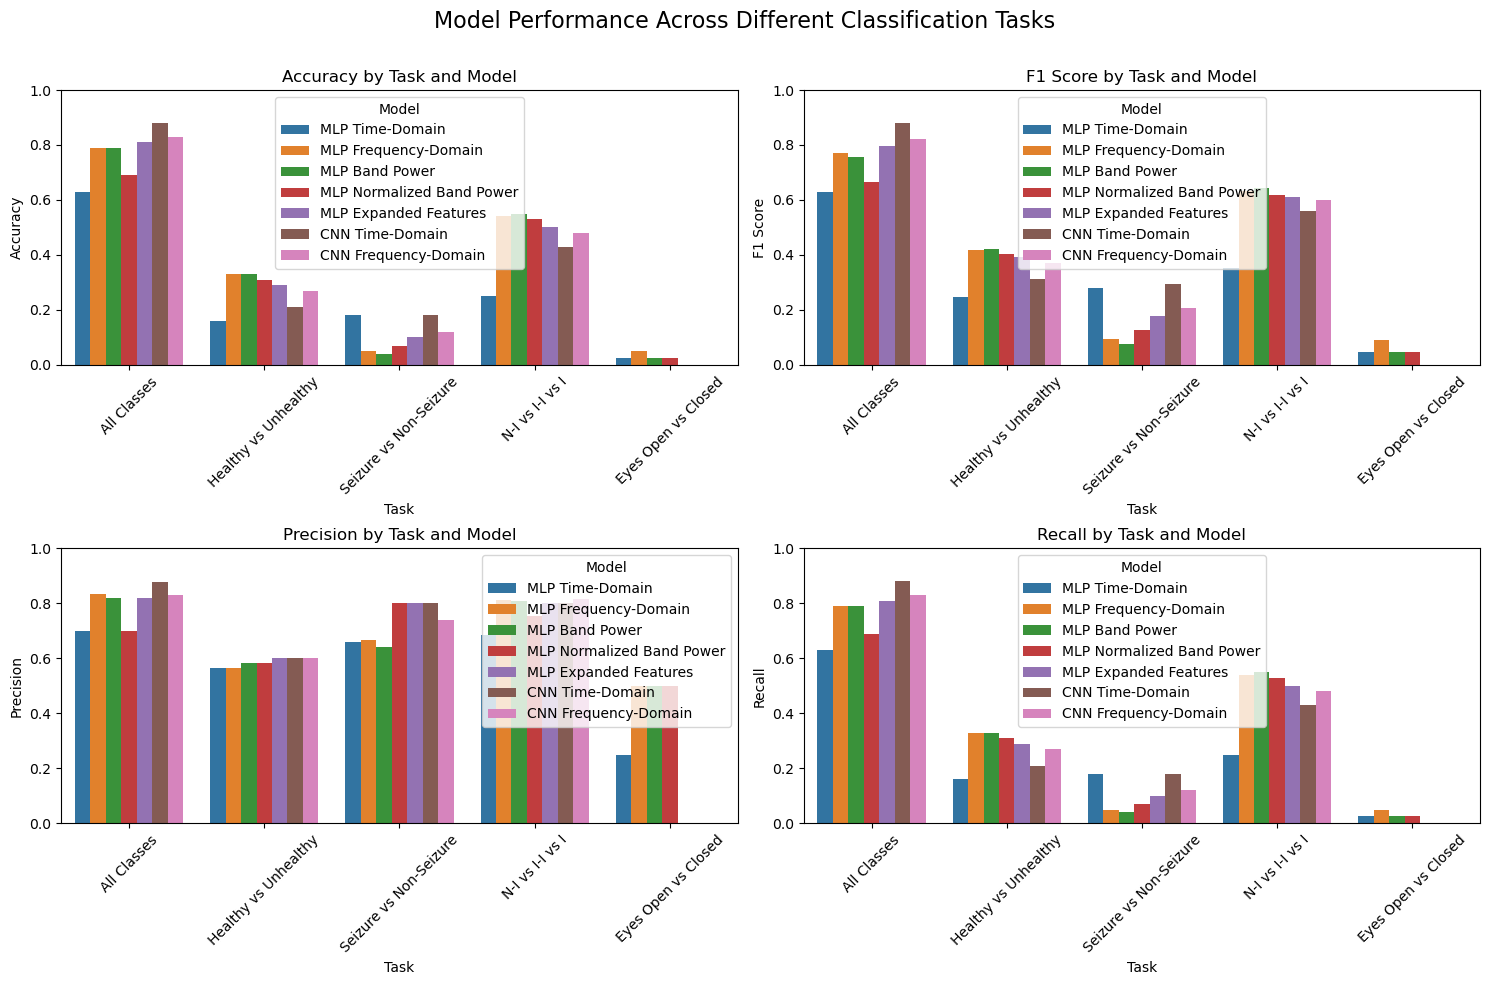

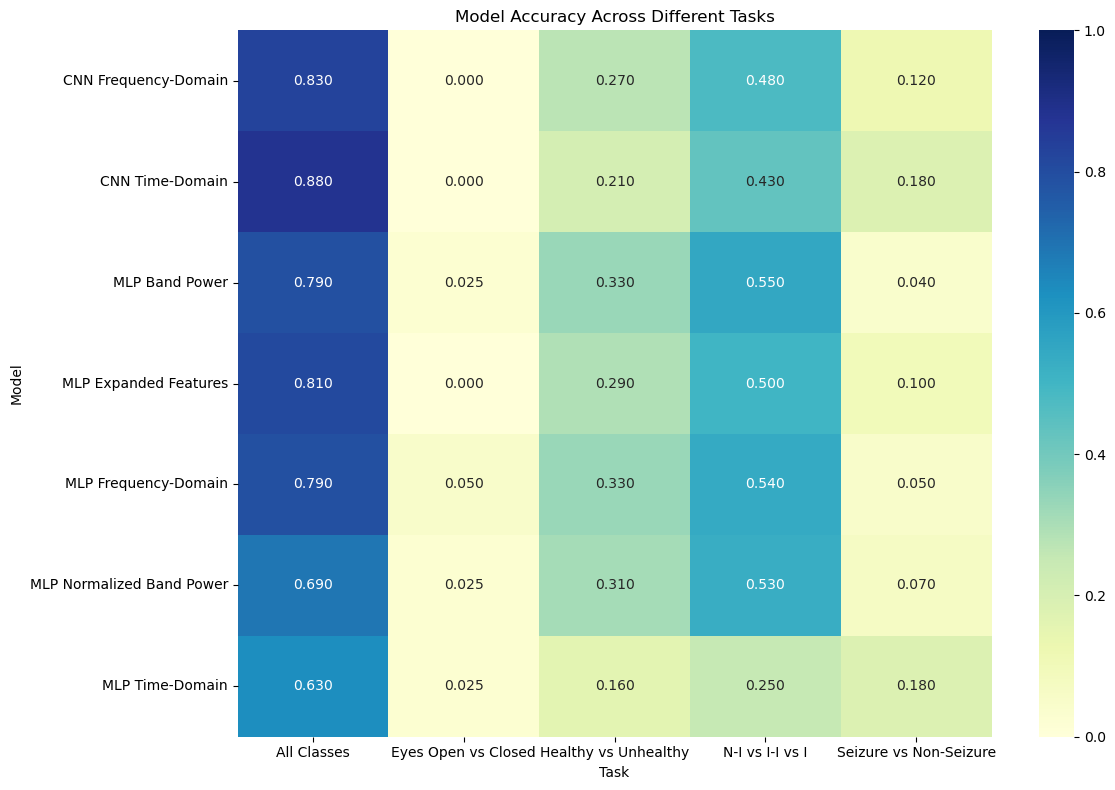

,Model,Task,Task Description,Accuracy,F1 Score,Precision,Recall
0,MLP Time-Domain,All Classes,All 5 EEG classes,0.630,0.629717,0.700833,0.630
1,MLP Time-Domain,Healthy vs Unhealthy,"Healthy (Z, O) vs Unhealthy (N, F, S)",0.160,0.247282,0.563095,0.160
2,MLP Time-Domain,Seizure vs Non-Seizure,"Seizure (S) vs Non-Seizure (Z, O, N, F)",0.180,0.280418,0.660119,0.180
3,MLP Time-Domain,N-I vs I-I vs I,"Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...",0.250,0.352739,0.683095,0.250
4,MLP Time-Domain,Eyes Open vs Closed,Eyes Open (Z) vs Eyes Closed (O) [Healthy only],0.025,0.045455,0.250000,0.025
5,MLP Frequency-Domain,All Classes,All 5 EEG classes,0.790,0.769977,0.835238,0.790
6,MLP Frequency-Domain,Healthy vs Unhealthy,"Healthy (Z, O) vs Unhealthy (N, F, S)",0.330,0.416842,0.565714,0.330
7,MLP Frequency-Domain,Seizure vs Non-Seizure,"Seizure (S) vs Non-Seizure (Z, O, N, F)",0.050,0.093023,0.666667,0.050
8,MLP Frequency-Domain,N-I vs I-I vs I,"Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...",0.540,0.634051,0.810476,0.540
9,MLP Frequency-Domain,Eyes Open vs Closed,Eyes Open (Z) vs Eyes Closed (O) [Healthy only],0.050,0.090909,0.500000,0.050



Best Models for Each Task:


,Task,Task Description,Model,Accuracy,F1 Score
25,All Classes,All 5 EEG classes,CNN Time-Domain,0.88,0.878558
9,Eyes Open vs Closed,Eyes Open (Z) vs Eyes Closed (O) [Healthy only],MLP Frequency-Domain,0.05,0.090909
6,Healthy vs Unhealthy,"Healthy (Z, O) vs Unhealthy (N, F, S)",MLP Frequency-Domain,0.33,0.416842
13,N-I vs I-I vs I,"Non-Ictal (Z, O) vs Inter-Ictal (N, F) vs. Ict...",MLP Band Power,0.55,0.643724
2,Seizure vs Non-Seizure,"Seizure (S) vs Non-Seizure (Z, O, N, F)",MLP Time-Domain,0.18,0.280418


In [81]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# remap the classes according to the task
def remap_classes(y_orig, mapping):
    y_remapped = []
    mask = []
    
    for i, cls in enumerate(y_orig):
        mapped_value = mapping.get(cls)
        if mapped_value is not None:
            y_remapped.append(mapped_value)
            mask.append(True)
        else:
            mask.append(False)
    
    return np.array(y_remapped), np.array(mask)

# evaluate a model on a specific task
def evaluate_model_on_task(model_info, task_info):
    model = model_info["model"]
    X_test = model_info["X_test"]
    y_true = model_info["y_test"]
    
    mapping = task_info["mapping"]

    # Remap the true labels according to the task
    y_remapped, mask = remap_classes(y_true, mapping)
    
    if len(y_remapped) == 0:
        return {"accuracy": np.nan, "f1": np.nan, "precision": np.nan, "recall": np.nan}
    
    # Get predictions on the test set
    y_pred_proba = model.predict(X_test[mask])
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Map the numeric predictions back to class names
    encoder = LabelEncoder().fit(y_remapped)
    class_names = encoder.classes_
    y_true_encoded = encoder.transform(y_remapped)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_encoded, y_pred)
    f1 = f1_score(y_true_encoded, y_pred, average='weighted')
    precision = precision_score(y_true_encoded, y_pred, average='weighted')
    recall = recall_score(y_true_encoded, y_pred, average='weighted')
    
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "classes": class_names
    }

# Create a results dataframe
results = []

# Evaluate each model on each task
for model_name, model_info in models.items():
    if model_info["model"] is None:
        print(f"Model {model_name} not trained.")
        continue  # Skip if the model wasn't stored
        
    for task_name, task_info in classification_tasks.items():
        metrics = evaluate_model_on_task(model_info, task_info)
        results.append({
            "Model": model_name,
            "Task": task_name,
            "Task Description": task_info["description"],
            "Accuracy": metrics["accuracy"],
            "F1 Score": metrics["f1"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"]
        })

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print(results_df)

# Visualizing the results
plt.figure(figsize=(15, 10))

# Plot accuracy comparison
plt.subplot(2, 2, 1)
sns.barplot(x="Task", y="Accuracy", hue="Model", data=results_df)
plt.title("Accuracy by Task and Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()

# Plot F1 score comparison
plt.subplot(2, 2, 2)
sns.barplot(x="Task", y="F1 Score", hue="Model", data=results_df)
plt.title("F1 Score by Task and Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()

# Plot precision comparison
plt.subplot(2, 2, 3)
sns.barplot(x="Task", y="Precision", hue="Model", data=results_df)
plt.title("Precision by Task and Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()

# Plot recall comparison
plt.subplot(2, 2, 4)
sns.barplot(x="Task", y="Recall", hue="Model", data=results_df)
plt.title("Recall by Task and Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Model Performance Across Different Classification Tasks", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Create a heatmap for accuracy across models and tasks
plt.figure(figsize=(12, 8))
heatmap_data = results_df.pivot(index="Model", columns="Task", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".3f")
plt.title("Model Accuracy Across Different Tasks")
plt.tight_layout()
plt.show()

# Display the complete results table
display(results_df)

# Summary of best models for each task
best_models = results_df.loc[results_df.groupby("Task")["Accuracy"].idxmax()]
print("\nBest Models for Each Task:")
display(best_models[["Task", "Task Description", "Model", "Accuracy", "F1 Score"]])